In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml 
import cv2
import os
import pandas as pd
from skimage.measure import regionprops, regionprops_table
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import pickle

## Pre-processing: Extract Marker Expression Levels
- Normalizing and channel selection already done
- Bounding box size: (33, 33) - based on estimates from Assn1 whole cell segmentation mask sizes

In [2]:
# Pre-processing helper functions
def extract_marker_expression(X, y, cell_types, w, h):
    """
    Crop cells based on bounding box size and extract marker expression levels    
    """
    # Find cell centroids based on cell nuclei segmentation masks (0)
    nucleus_cells = y[:,:,0]
    n_markers = np.shape(X)[2]
    
    exp_X = []
    exp_y = []
    exp_ids = []

    # Iterate through nuclei
    n_nuclei = np.max(nucleus_cells)

    if cell_types == None:
        r = range(n_nuclei+1)
    else: 
        r = range(1, n_nuclei+1)
    for idx in r: # nuclei segmentation mask id; skip 0 (background)
        # Extract information about cell type
        if cell_types != None:
            exp_y.append(cell_types[idx])
        exp_ids.append(idx)
        
        # Find centroid of nucleus using regionprops
        nucleus_mask = (nucleus_cells == idx).astype(np.uint8)
        y,x = regionprops(nucleus_mask)[0].centroid
        
        # Crop cell
        max_x = np.shape(nucleus_mask)[0]
        max_y = np.shape(nucleus_mask)[1]
        cropped_cell = X[max(math.floor(y-(h/2)),0):min(math.ceil(y+(h/2)),max_y), max(math.floor(x-(w/2)),0):min(math.ceil(x+(w/2)),max_x), :]
        
        # Calculate mean expression for each channel in cropped cell area
        exp_X.append(np.mean(cropped_cell, axis=(0,1)))
    
    return exp_X, exp_y, exp_ids

def preprocess(X, y, cell_types, w, h, normalize = False):
    """
    Pre-process and return mean marker expression for given data
    """
    # Reshape data
    X = np.squeeze(X, axis=0)
    y = np.squeeze(y, axis=0)
    if cell_types != None:
        cell_types = cell_types.item()

    # Extract expression data
    exp_X, exp_y, exp_ids = extract_marker_expression(X, y, cell_types, w, h)
    
    return exp_X, exp_y, exp_ids

def preprocess_all(folder, dataset, w, h):
    """
    Pre-process and save mean marker expressions for all files in folder
    """
    with open(folder+dataset+'2.yaml', 'r') as stream:
        cell_info = yaml.safe_load(stream)
    markers = cell_info['channels']

    df_cols = markers.copy()
    df_cols.extend(['cell_type', 'segmentation_mask_id'])

    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if dataset in f and 'expression' not in f and 'yaml' not in f:
            print(f)
            if filename.split('.npz')[0]+'_expression.csv' not in os.listdir(folder):
                data = np.load(f, allow_pickle = True)
                exp_X, exp_y, exp_ids = preprocess(data['X'], data['y'], data['cell_types'], w, h)

                # Save as csv
                n_cells = np.shape(exp_y)[0]
                all_data = np.hstack((exp_X, np.reshape(exp_y, (n_cells, 1)), np.reshape(exp_ids, (n_cells,1))))
                df = pd.DataFrame(all_data, columns = df_cols)
                df.to_csv(f.split('.npz')[0]+'_expression.csv', index = False)

In [27]:
# Extract marker expression - box size based on Assn1 estimates
#preprocess_all('assignment4/', 'keren', 33, 33)
#preprocess_all('assignment4/', 'risom', 33, 33)

## Combine Data

In [2]:
def combine_expression_data(folder, dataset):
    """
    Combine data from individual CSV files to get overall mean expression
    """
    combined_df = pd.DataFrame()
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if 'expression.csv' in f and dataset in f and 'combined' not in f:
            #print(f)
            df = pd.read_csv(f)
            combined_df = pd.concat([combined_df, df])

    return combined_df

def plot_heatmap(df, markers, cell_type_names):
    # Group by cell type, take mean
    grouped_df = df.groupby(['cell_type'])[markers].mean()

    # Heatmap for cell expression by cell type
    plt.figure(figsize = (16,5))
    s = sns.heatmap(grouped_df, yticklabels=cell_type_names)
    s.set(xlabel='Marker', ylabel='Cell type', title='Marker Expression Panel')

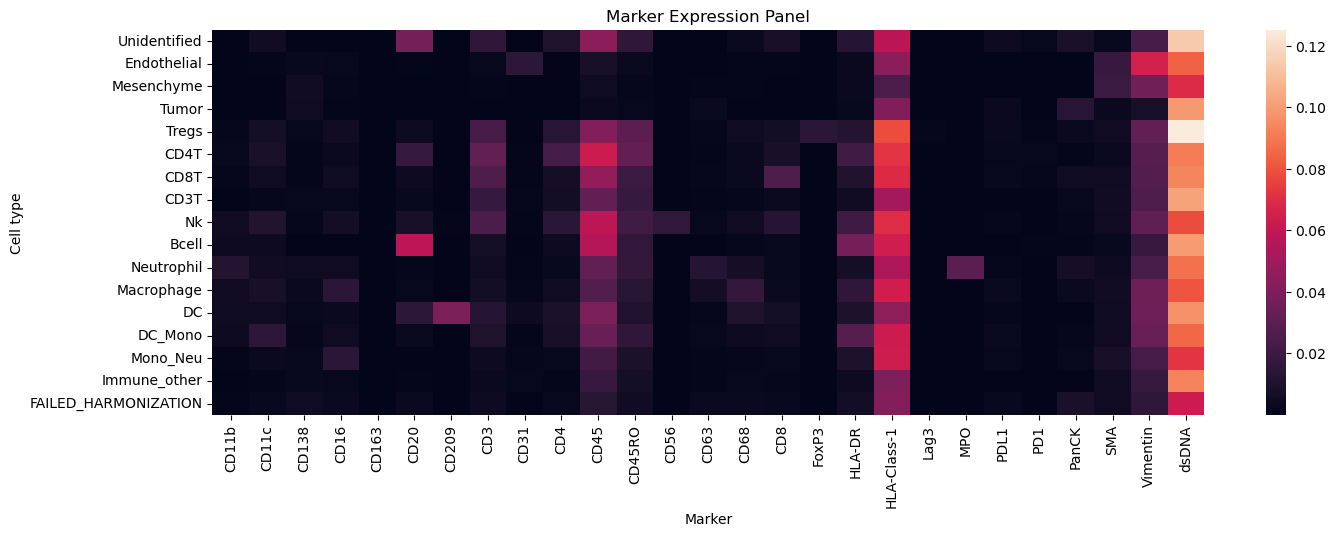

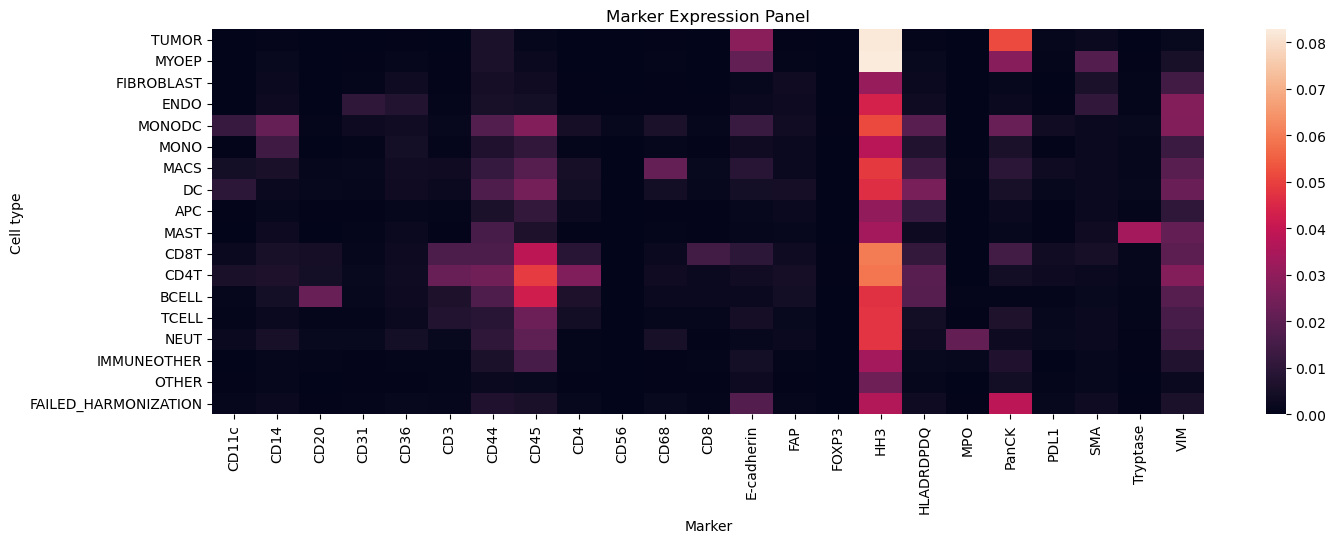

In [5]:
# Combine files from each dataset
folder = 'assignment4/'
dataset = 'keren'

for dataset in ['keren', 'risom']:
    with open(folder+dataset+'2.yaml', 'r') as stream:
        cell_info = yaml.safe_load(stream)
    markers = cell_info['channels']
    cell_types = cell_info['cell_types'].values()

    # Combine by dataset into consolidated dataframe
    df = combine_expression_data(folder, dataset)
    df.to_csv(folder+dataset+'_combined_expression.csv', index = False)
    plot_heatmap(df, markers, list(cell_types)[1:])

In [3]:
def standardize_cell_types_channels(df, dataset):
    """
    Standardizes cell-type identifier numbers and channel (marker) names
    across keren and risom datasets. 
    Returns dataframe with standardized cell-type numbers and channel names.
    """
    keren_dict = {0.0: 'Background',
              1.0: 'Unidentified',
              2.0: 'Endothelial',
              3.0: 'Mesenchyme',
              4.0: 'Tumor',
              5.0: 'Tregs',
              6.0: 'CD4T',
              7.0: 'CD8T',
              8.0: 'CD3T',
              9.0: 'Nk',
              10.0: 'Bcell',
              11.0: 'Neutrophil',
              12.0: 'Macrophage',
              13.0: 'DC',
              14.0: 'DC_Mono',
              15.0: 'Mono_Neu',
              16.0: 'Immune_other',
              17.0: 'FAILED_HARMONIZATION'}
    risom_dict = {0.0: 'BACKGROUND',
                  1.0: 'TUMOR',
                  2.0: 'MYOEP',
                  3.0: 'FIBROBLAST',
                  4.0: 'ENDO',
                  5.0: 'MONODC',
                  6.0: 'MONO',
                  7.0: 'MACS',
                  8.0: 'DC',
                  9.0: 'APC',
                  10.0: 'MAST',
                  11.0: 'CD8T',
                  12.0: 'CD4T',
                  13.0: 'BCELL',
                  14.0: 'TCELL',
                  15.0: 'NEUT',
                  16.0: 'IMMUNEOTHER',
                  17.0: 'OTHER',
                  18.0: 'FAILED_HARMONIZATION'}
    risom_name_dict = {'BACKGROUND': 'Background', 
                         'ENDO': 'Endothelial', 
                         'TUMOR': 'Tumor', 
                         'BCELL': 'Bcell', 
                         'NEUT': 'Neutrophil',
                         'MACS': 'Macrophage', 
                         'MONODC': 'DC_Mono', 
                         'MONO': 'Mono_Neu', 
                         'IMMUNEOTHER': 'Immune_other',
                         'MYOEP': 'Myoepithelial', 
                         'FIBROBLAST': 'Fibroblast', 
                         'MAST': 'Mast', 
                         'OTHER': 'Other', 
                         'TCELL': 'Tcell'}
    common_dict = {'Background': 0.0,
                  'Unidentified': 1.0,
                  'Endothelial': 2.0,
                  'Mesenchyme': 3.0,
                  'Tumor': 4.0,
                  'Tregs': 5.0,
                  'CD4T': 6.0,
                  'CD8T': 7.0,
                  'CD3T': 8.0,
                  'Nk': 9.0,
                  'Bcell': 10.0,
                  'Neutrophil': 11.0,
                  'Macrophage': 12.0,
                  'DC': 13.0,
                  'DC_Mono': 14.0,
                  'Mono_Neu': 15.0,
                  'Immune_other': 16.0,
                  'FAILED_HARMONIZATION': 17.0,
                  'Myoepithelial': 18.0,
                  'Fibroblast': 19.0,
                  'APC': 20.0,
                  'Mast': 21.0,
                  'Other': 22.0,
                  'Tcell': 23.0}
    if dataset == 'keren':
        df = df.replace({'cell_type':keren_dict})
    elif dataset == 'risom':
        df = df.replace({'cell_type':risom_dict})
        df = df.replace({'cell_type':risom_name_dict})
        df = df.rename(columns = {'FOXP3':'FoxP3', 'HLADRDPDQ':'HLA-DR', 'VIM':'Vimentin'})
    
    df = df.replace({'cell_type':common_dict})
    
    return df

def convert_cell_type_og(df, dataset):
    """
    Converts cell type identifiers back to original dataset identifiers.
    """
    common_dict_rev = {0.0: 'Background',
                      1.0: 'Unidentified',
                      2.0: 'Endothelial',
                      3.0: 'Mesenchyme',
                      4.0: 'Tumor',
                      5.0: 'Tregs',
                      6.0: 'CD4T',
                      7.0: 'CD8T',
                      8.0: 'CD3T',
                      9.0: 'Nk',
                      10.0: 'Bcell',
                      11.0: 'Neutrophil',
                      12.0: 'Macrophage',
                      13.0: 'DC',
                      14.0: 'DC_Mono',
                      15.0: 'Mono_Neu',
                      16.0: 'Immune_other',
                      17.0: 'FAILED_HARMONIZATION',
                      18.0: 'Myoepithelial',
                      19.0: 'Fibroblast',
                      20.0: 'APC',
                      21.0: 'Mast',
                      22.0: 'Other',
                      23.0: 'Tcell'}
    keren_dict_rev = {'Background': 0.0,
                      'Unidentified': 1.0,
                      'Endothelial': 2.0,
                      'Mesenchyme': 3.0,
                      'Tumor': 4.0,
                      'Tregs': 5.0,
                      'CD4T': 6.0,
                      'CD8T': 7.0,
                      'CD3T': 8.0,
                      'Nk': 9.0,
                      'Bcell': 10.0,
                      'Neutrophil': 11.0,
                      'Macrophage': 12.0,
                      'DC': 13.0,
                      'DC_Mono': 14.0,
                      'Mono_Neu': 15.0,
                      'Immune_other': 16.0,
                      'FAILED_HARMONIZATION': 17.0, 
                      'Myoepithelial': 18.0, 
                      'Fibroblast': 18.0,
                      'APC': 18.0,
                      'Mast': 18.0,
                      'Other': 18.0,
                      'Tcell': 18.0}
    risom_dict_rev = {'Background': 0.0,
                      'Tumor': 1.0,
                      'Myoepithelial': 2.0, 
                      'Fibroblast': 3.0,
                      'Endothelial': 4.0,
                      'DC_Mono': 5.0,
                      'Mono_Neu': 6.0,
                      'Macrophage': 7.0,
                      'DC': 8.0,
                      'APC': 9.0,
                      'Mast': 10.0,
                      'CD8T': 11.0,
                      'CD4T': 12.0,
                      'Bcell': 13.0,
                      'Tcell': 14.0,
                      'Neutrophil': 15.0,
                      'Immune_other': 16.0,
                      'Other': 17.0, 
                      'FAILED_HARMONIZATION': 18.0,
                      'Unidentified': 19.0,
                      'Mesenchyme': 19.0,
                      'Tregs': 19.0,
                      'CD3T': 19.0,
                      'Nk': 19.0, 
                      'Other': 19.0}
    
    df = df.replace({'cell_type': common_dict_rev})
    
    if dataset == 'keren':
        df = df.replace({'cell_type':keren_dict_rev})
    elif dataset == 'risom':
        df = df.replace({'cell_type':risom_dict_rev})
        
    return df

def select_cell_types(df):
    """
    Select celltypes (remove Background, Unidentified, Other, and FAILED_HARMONIZATION)
    """
    selected_cell_types = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23]
    selected_cell_type_names = ['Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T',
                                'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 
                                'Immune_other', 'Myoepithelial', 'Fibroblast', 'APC', 'Mast', 'Tcell']
    
    selected_df = df.loc[df['cell_type'].isin(selected_cell_types)]
    return selected_df, selected_cell_type_names

In [67]:
# Combine data from two datasets
keren_df = pd.read_csv('assignment4/keren_combined_expression.csv')
risom_df = pd.read_csv('assignment4/risom_combined_expression.csv')

# Standardize cell type numbers and channel names
keren_df = standardize_cell_types_channels(keren_df, 'keren')
risom_df = standardize_cell_types_channels(risom_df, 'risom')

# Merge datasets
combined_df = pd.concat([keren_df, risom_df], axis = 0, ignore_index = True)

# Move cell_type and segmentation_mask_id to end
cols = list(combined_df.columns.values)
cols.pop(cols.index('cell_type'))
cols.pop(cols.index('segmentation_mask_id'))
combined_df = combined_df[cols+['cell_type','segmentation_mask_id']] 

# Dataset with only common channels
combined_df_common = combined_df.dropna(axis='columns')

# Save all datasets
keren_df.to_csv('assignment4/keren_df.csv', index = False)
risom_df.to_csv('assignment4/risom_df.csv', index = False)
combined_df.to_csv('assignment4/combined_df.csv', index = False)
combined_df_common.to_csv('assignment4/combined_df_common.csv', index = False)

# Models

## Linear Model (Baseline)

In [3]:
# Linear model baseline
def load_data_linear(filepath):
    """
    Loads in data from .csv dataframe file and creates training and test data
    """
    df = pd.read_csv(filepath)
    
    # Select cell-types
    df, selected_cell_types = select_cell_types(df)
    n_cols = len(df.columns)
    
    # Fill in NaN
    df = df.fillna(0)

    # Convert to X and y (one-hot encoded)
    X = df.iloc[:,0:n_cols-2]
    y = df.iloc[:,n_cols-2:n_cols-1]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    ids = df.iloc[:,n_cols-1:]

    # Convert to tensors
    X = torch.tensor(X.values, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Split into train/test data
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, shuffle=True)

    # Make dataset and dataloader for training data
    train_dataset = TensorDataset(train_X, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle = True)

    return train_loader, test_X, test_y

class LinearClassifier(torch.nn.Module):
    """
    Simple linear classifier model
    """
    def __init__(self):
        super().__init__()
        #self.output = nn.Linear(43, 15) # for selected cell types only
        self.output = nn.Linear(34, 20) # for all cell types
 
    def forward(self, x):
        x = self.output(x)
        return x
    
def train_linear_model(train_loader, model, lr, optimizer, loss_fn, num_epochs):
    """
    Trains model using training dataset and returns trained model
    """
    model.train()

    train_losses = np.zeros(num_epochs)
    train_accuracies = np.zeros(num_epochs)
    N_train = len(train_loader.dataset)

    for epoch in range(num_epochs):
          total_correct = 0
          train_loss = 0

          for batch_idx, (data, target) in enumerate(train_loader):
              # Erase accumulated gradients
              optimizer.zero_grad()

              # Forward pass
              output = model(data)

              # Calculate loss/accuracy
              loss = loss_fn(output, target)
              train_loss += loss.item()

              pred = output
              total_correct += (1*(torch.argmax(pred, 1) == torch.argmax(target, 1))).sum().item()

              # Backward pass
              loss.backward()

              # Weight update
              optimizer.step()

          train_loss /= N_train
          train_accuracy = total_correct / N_train

          # Track loss each 10 epoch
          if epoch % 10 == 0:
              print('Train Epoch: %d  Loss: %.4f  Accuracy %.4f' % (epoch + 1,  
                      train_loss, 
                      train_accuracy))

          # Save to arrays
          train_losses[epoch] = train_loss
          train_accuracies[epoch] = train_accuracy

    return model, train_losses, train_accuracies

def test_linear_model(test_X, test_y, model):
    """
    Tests trained model on holdout set
    """
    model.eval()
    pred = model(test_X)
    pred = torch.argmax(pred,1)
    y = torch.argmax(test_y,1)
    accuracy = (1*(pred == y)).float().mean()
    print('Test accuracy: %.4f' % accuracy)

    return pred, y, accuracy

def train_test_linear_model(filepath, model_name):
    """
    Trains and tests the linear classifier model using a combined dataframe .csv file
    """
    # Set-up data and model
    train_loader, test_X, test_y, = load_data_linear(filepath)
    model = LinearClassifier()
    lr = 1e-2
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss()

    # Train and test model
    model, train_losses, train_accuracies = train_linear_model(train_loader, model, lr, optimizer, loss_fn, 100)
    test_pred, test_y, test_accuracy = test_linear_model(test_X, test_y, model)

    torch.save(model, 'assignment4/'+model_name+'.pt')

    # Plot training losses / accuracies
    plt.plot(train_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(train_accuracies)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    # Confusion matrix
    conf_matrix = confusion_matrix(test_y, test_pred)
    normalized_conf_matrix = [] 
    for i in range(len(conf_matrix)):
        normalized_conf_matrix.append(conf_matrix[i] / np.sum(conf_matrix[i]))

    sns.set(font_scale=0.5)
    s = sns.heatmap(normalized_conf_matrix, cmap='Blues', annot = True, fmt=".2f",
                yticklabels = selected_cell_type_names, xticklabels = selected_cell_type_names)
    s.set(xlabel='Predicted', ylabel = 'True')

Train Epoch: 1  Loss: 0.0022  Accuracy 0.4871
Train Epoch: 11  Loss: 0.0011  Accuracy 0.6599
Train Epoch: 21  Loss: 0.0009  Accuracy 0.7029
Train Epoch: 31  Loss: 0.0009  Accuracy 0.7292
Train Epoch: 41  Loss: 0.0008  Accuracy 0.7469
Train Epoch: 51  Loss: 0.0008  Accuracy 0.7566
Train Epoch: 61  Loss: 0.0007  Accuracy 0.7624
Train Epoch: 71  Loss: 0.0007  Accuracy 0.7666
Train Epoch: 81  Loss: 0.0007  Accuracy 0.7694
Train Epoch: 91  Loss: 0.0007  Accuracy 0.7719
Test accuracy: 0.7720


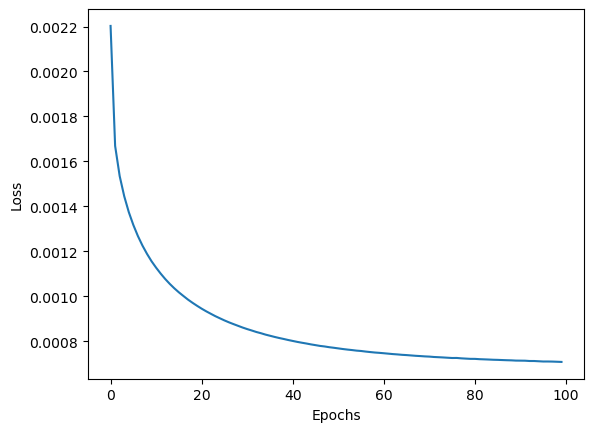

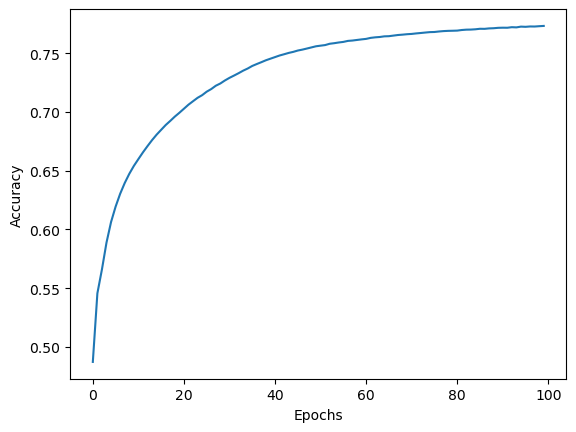

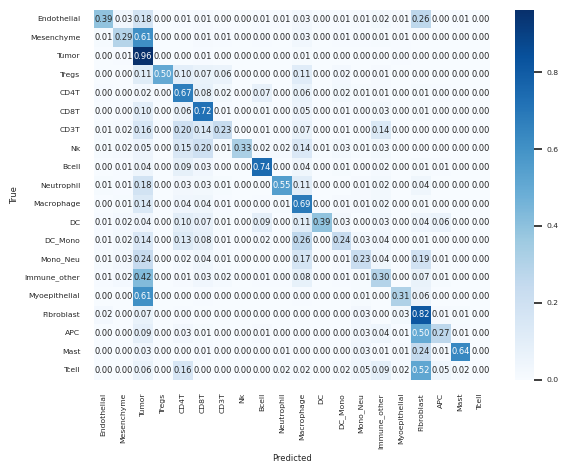

In [4]:
filepath = 'assignment4/combined_df.csv'
# Uncomment to train model
selected_cell_type_names = ['Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T',
                                'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 
                                'Immune_other', 'Myoepithelial', 'Fibroblast', 'APC', 'Mast', 'Tcell']
    
train_test_linear_model(filepath, 'linear_model_selected')

## New models

In [47]:
def load_data_new(filepath):
    """
    Loads in data from .csv dataframe file and creates training and test data
    """
    df = pd.read_csv(filepath)
    
    # Select cell-types
    df, selected_cell_types = select_cell_types(df)
    n_cols = len(df.columns)
    
    # Fill in NaN
    df = df.fillna(0)

    # Convert to X and y
    X = df.iloc[:,0:n_cols-2]
    y = df.iloc[:,n_cols-2]
    ids = df.iloc[:,n_cols-1]

    # Split into train/test data
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, shuffle=True)

    return train_X, train_y, test_X, test_y

def train_test_new_model(filepath, model_name):
    """
    Trains and tests a SVM using a combined dataframe .csv file
    """
    print(model_name)
    
    # Set-up data and model
    train_X, train_y, test_X, test_y, = load_data_new(filepath)
    
    if 'svm' in model_name:
        model = svm.LinearSVC(tol = 1e-6)
    if 'rf' in model_name:
        model = RandomForestClassifier(n_estimators = 25, max_depth = 16)
    if 'ada' in model_name:
        model = AdaBoostClassifier(n_estimators=30, estimator = DecisionTreeClassifier(max_depth=20))
    if 'nb' in model_name:
        model = GaussianNB()
    
        # Hyperparameter tuning
        #params = {'n_estimators':[50,100,500,1000], 'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':[50,100,1000, None]}
        #model = GridSearchCV(RandomForestClassifier(), params)
        #model.fit(train_X, train_y)
    
    # Train and test model
    model.fit(train_X, train_y)
    train_pred = model.predict(train_X)
    print("Train accuracy:", metrics.accuracy_score(train_y, train_pred))
    
    test_pred = model.predict(test_X)
    print("Test accuracy:", metrics.accuracy_score(test_y, test_pred))

    with open('assignment4/'+model_name+'.pkl','wb') as f:
        pickle.dump(model,f)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_y, test_pred)
    normalized_conf_matrix = [] 
    for i in range(len(conf_matrix)):
        normalized_conf_matrix.append(conf_matrix[i] / np.sum(conf_matrix[i]))

    sns.set(font_scale=0.5)
    s = sns.heatmap(normalized_conf_matrix, cmap='Blues', annot = True, fmt=".2f",
                yticklabels = selected_cell_type_names, xticklabels = selected_cell_type_names)
    s.set(xlabel='Predicted', ylabel = 'True')
    plt.show()

rf_selected
Train accuracy: 0.8923994532134389
Test accuracy: 0.8021571977787271


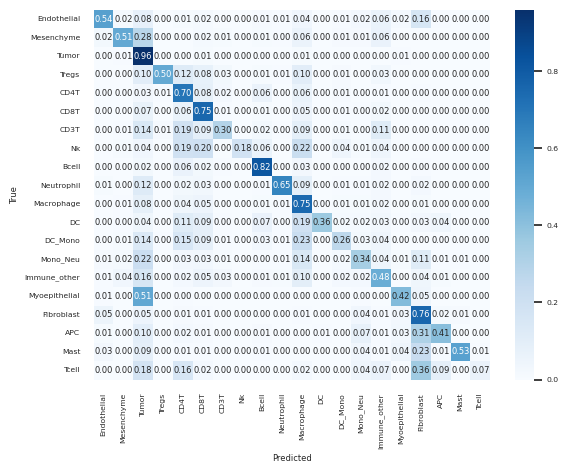

In [52]:
filepath = 'assignment4/combined_df.csv'
# Uncomment to train model
selected_cell_type_names = ['Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T',
                                'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 
                                'Immune_other', 'Myoepithelial', 'Fibroblast', 'APC', 'Mast', 'Tcell']
    
#train_test_new_model(filepath, 'svm_selected')
train_test_new_model(filepath, 'rf_selected')
#train_test_new_model(filepath, 'adaboost_selected')
#train_test_new_model(filepath, 'nb_selected')

## External data testing

In [49]:
def test_new_model_external_selected(X, y, model, dataset):
    """
    Takes in X, y, and a trained model and returns a dictionary 
    mapping segmentation mask ids to predicted cell types
    """
    # Pre-processing
    exp_X, _, exp_ids = preprocess(X, y, None, 33, 33)

    # Convert to pandas DataFrame
    n_cells = np.shape(exp_ids)[0]
    all_data = exp_X
    with open('assignment4/'+dataset+'2.yaml', 'r') as stream:
        cell_info = yaml.safe_load(stream)
    markers = cell_info['channels']
    df_cols = markers.copy()
        
    df = pd.DataFrame(all_data, columns = df_cols)
    if dataset == 'risom':
        df = df.rename(columns = {'FOXP3':'FoxP3', 'HLADRDPDQ':'HLA-DR', 'VIM':'Vimentin'})

    all_cols = ['CD11b', 'CD11c', 'CD138', 'CD16', 'CD163', 'CD20', 'CD209', 'CD3',
       'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56', 'CD63', 'CD68', 'CD8', 'FoxP3',
       'HLA-DR', 'HLA-Class-1', 'Lag3', 'MPO', 'PDL1', 'PD1', 'PanCK', 'SMA',
       'Vimentin', 'dsDNA', 'CD14', 'CD36', 'CD44', 'E-cadherin', 'FAP', 'HH3',
       'Tryptase']
    for col in all_cols:
        if col not in df.columns:
            df[col] = 0
    
    # Re-order columns
    df = df[all_cols]

    test_X = df

    # Test on model
    pred = model.predict(test_X)

    # Convert back to original cell-type identifiers 
    pred = convert_cell_type_og(pd.DataFrame(pred, columns = ['cell_type']), dataset)
    pred = pred['cell_type'].tolist()

    # Create dictionary
    pred_dict = dict(zip(exp_ids, pred))

    return pred_dict

In [50]:
# Selected cell type only trained model
## CHANGE FILEPATH HERE:
#filepath = 'assignment4/keren15.npz'
filepath = 'assignment4/risom10.npz'

if 'keren' in filepath:
    dataset = 'keren'
elif 'risom' in filepath:
    dataset = 'risom'

#model = torch.load('linear_model_selected.pt')
with open('assignment4/rf_selected.pkl', 'rb') as f:
    model = pickle.load(f)

data = np.load(filepath, allow_pickle=True)
X = data['X']
y = data['y']
cell_types = data['cell_types'].item()

print('Data loaded')

# Call to the function
pred_dict = test_new_model_external_selected(X, y, model, dataset)

if dataset == 'keren':
    removed_cell_types = [0, 1, 17]
else:
    removed_cell_types = [0, 17, 18]
    
sum = 0
sum_selected = 0
n_selected_cells = 0
for key in pred_dict:
    if cell_types[key] not in removed_cell_types: # cell types that were removed from training set
        n_selected_cells += 1
        if pred_dict[key] == cell_types[key]:
            sum_selected += 1
    if pred_dict[key] == cell_types[key]:
        sum += 1
print('Overall accuracy: %.4f' % (sum / len(pred_dict)))
print('Accuracy of selected cell types only: %.4f' % (sum_selected / n_selected_cells))


Data loaded
Overall accuracy: 0.6390
Accuracy of selected cell types only: 0.9019
